# Selection of PET FDG images to process

In [1]:
import os
import pandas as pd 
import numpy as np
from tableone import TableOne

In [2]:
dir = '/scratch/caroline/papers/ongoing/project00/ADNI_analysis/data'
adni1 = pd.read_csv(os.path.join(dir, 'adni_fdg_pet_selection.csv'))

## Organize data

In [3]:
# Remove unnecessary columns
adni2 = adni1.drop(columns=['0','2','3','5', 'time', 'time0', 'date0']) 
# Rename id columns
adni2 = adni2.rename(columns={'4':'Other_ID', 'date':'fdg_scandate'})

#Organize order
adni2 = adni2[['project', 'Individual', 'AltId', 'Other_ID','ID', 'TimePoint', 'GUID', 'freesurfer_6_0_0_aparc_thickness_GUID',  
               'scandate',  'fdg_scandate', 'date_diff', 'HMSTROKE', 'DXPARK','MMSCORE', 'CDGLOBAL', 'PTDOBMM', 'PTDOBYY']]

In [4]:
# Step 1: Drop rows with missing month or year of birth
adni3 = adni2.dropna(subset=["PTDOBMM", "PTDOBYY"]).copy()  

#change to integer
adni3[['PTDOBMM', 'PTDOBYY']] = adni3[['PTDOBMM', 'PTDOBYY']].astype(np.int64)

# put MM and YY of birth together and change to datetime format
adni3['DOB'] = adni3['PTDOBYY'].astype(str) + adni3['PTDOBMM'].astype(str)
adni3['DOB'] = pd.to_datetime(adni3['DOB'], format='%Y%m')


In [5]:
adni3['fdg_scandate'] = pd.to_datetime(adni3['fdg_scandate'])
adni3['scandate'] = pd.to_datetime(adni3['scandate'])

# Calculate age at FDG scan
adni3['age_FDG'] = adni3['fdg_scandate'] - adni3['DOB']
adni3['age_FDG'] = adni3['age_FDG']/pd.Timedelta('365.25 days')
adni3['age_FDG'] = adni3['age_FDG'].round(2)
# Calculate age at MRI scan
adni3['age_MRI'] = adni3['scandate'] - adni3['DOB']
adni3['age_MRI'] = adni3['age_MRI']/pd.Timedelta('365.25 days')
adni3['age_MRI'] = adni3['age_MRI'].round(2)
#1446 Ids


In [6]:
adni3 = adni3[(adni3['HMSTROKE']==0)].copy()

In [7]:
fs_keys = adni3[['freesurfer_6_0_0_aparc_thickness_GUID']]

# Diagnosis

In [8]:
# Load
diag = pd.read_csv(os.path.join(dir, 'ADNI_DIAGNOSIS_20250616.csv'))

adni_diag = diag.copy()
#change missing to na, and None to na
adni_diag = adni_diag.replace('None', np.nan)
adni_diag = adni_diag.replace(-4, np.nan)
adni_diag = adni_diag.replace('-4', np.nan)

In [9]:
adni_diag.columns

Index(['Project', 'Individual', 'AltId', 'TimePoint', 'InputIds',
       'freesurfer_6_0_0_aparc_thickness_GUID', 'EXAMDATE', 'DXCHANGE',
       'DXCURREN', 'DXCONV', 'DXREV', 'DXNORM', 'DXMCI', 'DXMDES', 'DXMPTR1',
       'DXMDUE', 'DXMOTHET', 'DXDDUE', 'DXAD', 'DXAPP', 'DXAPOSS', 'DXPARK',
       'DXODES', 'DIAGNOSIS', 'BCSTROKE'],
      dtype='object')

In [10]:
# Fill in different timepoint
adni_diag = adni_diag.sort_values(by=['Individual', 'TimePoint'])

diagnosis_cols = [
    'DXCHANGE', 'DXCURREN', 'DXCONV', 'DXREV', 'DXNORM', 'DXMCI',
    'DXMDES', 'DXMPTR1', 'DXMDUE', 'DXMOTHET', 'DXDDUE', 'DXAD', 'DXAPP',
    'DXAPOSS', 'DXPARK', 'DXODES', 'DIAGNOSIS', 'BCSTROKE'
]

# Fill missing values for rows that share the same Individual and TimePoint
adni_diag[diagnosis_cols] = (
    adni_diag.groupby(['Individual', 'TimePoint'])[diagnosis_cols]
    .transform(lambda x: x.bfill().ffill())
)

#fill in the dates were there is no diagnosis assuming the previous diagnosis is still the actual diagnosis
adni_diag = adni_diag.sort_values(by=['Individual', 'EXAMDATE'])

diagnosis_cols = [
    'DXCHANGE', 'DXCURREN', 'DXCONV', 'DXREV', 'DXNORM', 'DXMCI',
    'DXMDES', 'DXMPTR1', 'DXMDUE', 'DXMOTHET', 'DXDDUE', 'DXAD', 'DXAPP',
    'DXAPOSS', 'DXPARK', 'DXODES', 'DIAGNOSIS', 'BCSTROKE'
]

# Fill missing values for rows that share the same Individual --> as we work with date, cannot be backwards, only forward
adni_diag[diagnosis_cols] = (
    adni_diag.groupby(['Individual'])[diagnosis_cols]
    .transform(lambda x: x.ffill())
)

/tmp/ipykernel_194097/869927213.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .transform(lambda x: x.bfill().ffill())
/tmp/ipykernel_194097/869927213.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .transform(lambda x: x.ffill())


In [11]:
#Diagnosis status

# varibale 'diag_current' is based on DIAGNOSIS and DXCURREN variables that should be the same
adni_diag['diag_current'] = np.where(pd.notna(adni_diag['DIAGNOSIS']),
                             adni_diag['DIAGNOSIS'],
                             adni_diag['DXCURREN'])


# variable diag_change is based on diag_current and DXCHANGE
adni_diag['diag_change'] = np.where(pd.notna(adni_diag['diag_current']),
                             adni_diag['diag_current'],
                             adni_diag['DXCHANGE'])

adni_diag['diagnosis_CD_raw'] = adni_diag['diag_change']

- Dictionary
- DXCHANGE:  Which best describes the participant's change in cognitive status from last visit to current visit:
 1=Stable: NL to NL; 2=Stable: MCI to MCI; 3=Stable: Dementia to Dementia; 4=Conversion: NL to MCI; 5=Conversion: MCI to Dementia; 6=Conversion: NL to Dementia; 7=Reversion: MCI to NL; 8=Reversion: Dementia to MCI; 9=Reversion: Dementia to NL
- DXCURREN:
 1=NL;2=MCI;3=AD
- DXCONV: Has there been a conversion or reversion to NL/MCI?
 1=Yes - Conversion;2=Yes - Reversion; 0=No
- DXREV:  If YES - REVERSION, choose type
 1=MCI to Normal Control; 2=AD to MCI; 3=AD to Normal Control
- DXNORM: Normal
 1=Yes
- DXMCI: 
 1=Yes
- DXMDES: If Mild Cognitive Impairment, select any that apply:
 1=MCI - Memory features (amnestic); 2=MCI - Non-memory features (non-amnestic)
 1=MCI (Memory features); 2=MCI (Non-memory features)
- DXMPTR1: If MCI - Memory features, complete the following (Petersen Criteria, see procedures manual for details): i. Subjective memory complaint
 1=Yes; 0=No
- DXMDUE: suspected cause of MCI
 1=MCI due to Alzheimer's Disease; 2=MCI due to other etiology
- DXMOTHET: If MCI due to other etiology, select box(es) to indicate reason:
 1=Fronto-temporal Dementia; 2=Parkinson's Disease; 3=Huntington's Disease; 4=Progressive Supranuclear Palsy; 8=Corticobasal Degeneration; 9=Vascular Dementia; 10=Prion-Associated Dementia; 14=Other (specify)
- DXDDUE:  3b. Suspected cause of dementia
 1=Dementia due to Alzheimer's Disease; 2=Dementia due to other etiology
- DXAD: Alzheimer's disease
 1=Yes
- DXAPP: If Dementia due to Alzheimer's Disease, indicate likelihood:
 1=Probable; 2=Possible
- DXAPOSS: If Possible AD, select box(es) to indicate reason:
 1=Atypical clinical course or features (specify); 2=Stroke(s); 3=Depression; 4=Delirium; 5=Parkinsonism; 6=Metabolic / Toxic Disorder (specify); 7=Other (specify)
- DXPARK:  4b. Parkinsonism symptoms present?
 1=Yes; 0=No
- DXODES:  If Other Dementia, select box which indicates best diagnosis:
 1=Frontal; 3=Huntington's Disease; 5=Alcohol-related Dementia; 6=NPH; 7=Major Depression; 9=Vascular Dementia; 10=Prion-Associated Dementia; 11=HIV; 12=Primary Progressive Aphasia; 13=Posterior Cortical Dysfunction; 14=Other (specify)
- DIAGNOSIS: 1. Which best describes the participant's current diagnosis?
 1=CN; 2=MCI; 3=Dementia
- BCSTROKE: 10. Did subject have a stroke? ( Diagnostic Summary - Baseline Changes)
 1=Yes; 0=No

In [12]:
# adni_diag.sort_values(by=['Individual', 'EXAMDATE'])
# adni_diag[['diagnosis_CD_raw']] = (
#     adni_diag.groupby('Individual')[['diagnosis_CD_raw']]
#     .transform(lambda group: group.bfill().ffill())
#     .reset_index(level=0, drop=True)  # Drop extra index added by groupby
# )

In [13]:
mytable = TableOne(adni_diag, columns=['diagnosis_CD_raw', 'diag_current', 'diag_change',
       'DXCHANGE', 'DXCURREN', 'DXCONV', 'DXREV', 'DXNORM', 'DXMCI', 'DXMDES', 'DXMPTR1',
       'DXMDUE', 'DXMOTHET', 'DXDDUE', 'DXAD', 'DXAPP', 'DXAPOSS', 'DXPARK',
       'DXODES', 'DIAGNOSIS', 'BCSTROKE'])
print(mytable.tabulate(tablefmt = "fancy_grid"))


╒═════════════════════════╤═════════╤═══════════╤══════════════╕
│                         │         │ Missing   │ Overall      │
╞═════════════════════════╪═════════╪═══════════╪══════════════╡
│ n                       │         │           │ 21312        │
├─────────────────────────┼─────────┼───────────┼──────────────┤
│ diagnosis_CD_raw, n (%) │ 1.0     │           │ 7205 (33.8)  │
├─────────────────────────┼─────────┼───────────┼──────────────┤
│                         │ 2.0     │           │ 9043 (42.4)  │
├─────────────────────────┼─────────┼───────────┼──────────────┤
│                         │ 3.0     │           │ 4166 (19.5)  │
├─────────────────────────┼─────────┼───────────┼──────────────┤
│                         │ 4.0     │           │ 86 (0.4)     │
├─────────────────────────┼─────────┼───────────┼──────────────┤
│                         │ 5.0     │           │ 288 (1.4)    │
├─────────────────────────┼─────────┼───────────┼──────────────┤
│                        

In [14]:
pd.crosstab(adni_diag['diagnosis_CD_raw'],adni_diag['diag_change'])

diag_change,1.0,2.0,3.0,4.0,5.0,7.0,8.0,None
diagnosis_CD_raw,,,,,,,,
1.0,7205,0,0,0,0,0,0,0
2.0,0,9043,0,0,0,0,0,0
3.0,0,0,4166,0,0,0,0,0
4.0,0,0,0,86,0,0,0,0
5.0,0,0,0,0,288,0,0,0
7.0,0,0,0,0,0,89,0,0
8.0,0,0,0,0,0,0,14,0
None,0,0,0,0,0,0,0,421


In [15]:
#%% Create new diagnosis (only 1, 2, 3) and calculate conversion time from baseline
# 1=Stable: NL to NL; 2=Stable: MCI to MCI; 3=Stable: Dementia to Dementia; 
# 4=Conversion: NL to MCI; 5=Conversion: MCI to Dementia; 6=Conversion: NL to Dementia; 
# 7=Reversion: MCI to NL; 8=Reversion: Dementia to MCI; 9=Reversion: Dementia to NL	
# Define mapping dictionary
diagnosis_mapping = {
    4: 2,
    5: 3,  
    6: 3,
    7: 1,
    8: 2,
    9: 1
}

adni_diag1 = adni_diag.copy()
# Apply mapping to the column
#remove None and convert to numeric to map properly
adni_diag1['diagnosis_CD_raw'] = adni_diag1['diagnosis_CD_raw'].replace('None', 77)# np.nan)
adni_diag1['diagnosis_CD'] = adni_diag1['diagnosis_CD_raw'].astype(float).replace(diagnosis_mapping)

#adni_diag1['diagnosis_CD'] = adni_diag1['diagnosis_CD'].replace('None', np.nan)
#adni_diag1['diagnosis_CD'] = adni_diag1['diagnosis_CD'].astype(float)
adni_diag1 = adni_diag1.dropna(subset=['diagnosis_CD'])

#change to datetime
adni_diag1['EXAMDATE'] = pd.to_datetime(adni_diag1['EXAMDATE'])
# Sort by Individual and EXAMDATE to ensure proper chronological order
adni_diag1 = adni_diag1.sort_values(by=['Individual', 'EXAMDATE'])
#Calculate time between tp
adni_diag1['time_from_bl'] = adni_diag1.groupby('Individual')['EXAMDATE'].transform(lambda x: (x - x.min()).dt.days / 365.25)

# Compute diagnosis change
adni_diag1['diagnosis_changed'] = adni_diag1.groupby('Individual')['diagnosis_CD'].transform(
    lambda x: x != x.shift()
)
# First record for each Individual: force to False
adni_diag1.loc[adni_diag1.groupby('Individual').head(1).index, 'diagnosis_changed'] = False

# Flag Ids that has changed before two years
adni_diag1['exclude_ID'] = (
    (adni_diag1['diagnosis_changed']) & 
    (adni_diag1['time_from_bl'] <= 1)
)


In [16]:
adni_diag1['diagnosis_CD'].value_counts()

diagnosis_CD
2.0     9143
1.0     7294
3.0     4454
77.0     421
Name: count, dtype: int64

In [17]:
pd.crosstab(adni_diag1['diagnosis_CD_raw'],adni_diag1['diagnosis_CD'])

diagnosis_CD,1.0,2.0,3.0,77.0
diagnosis_CD_raw,,,,
77,0,0,0,421
1.0,7205,0,0,0
2.0,0,9043,0,0
3.0,0,0,4166,0
4.0,0,86,0,0
5.0,0,0,288,0
7.0,89,0,0,0
8.0,0,14,0,0


In [18]:
adni_diag1['cn_to_mci'] = (
    (adni_diag1['diagnosis_CD'].shift() == 1) &   # Previous was MCI
    (adni_diag1['diagnosis_CD'] == 2) &           # Current is AD
    (adni_diag1['diagnosis_changed']) &           # Must be a real change
    (adni_diag1['time_from_bl'] > 0)              # Not baseline
)

adni_diag1['mci_to_ad'] = (
    (adni_diag1['diagnosis_CD'].shift() == 2) &   # Previous was MCI
    (adni_diag1['diagnosis_CD'] == 3) &           # Current is AD
    (adni_diag1['diagnosis_changed']) &           # Must be a real change
    (adni_diag1['time_from_bl'] > 0)              # Not baseline
)
mytable = TableOne(adni_diag1, columns=['diagnosis_CD', 'diagnosis_changed', 'exclude_ID', 'cn_to_mci', 'mci_to_ad', 'diagnosis_CD_raw'])
print(mytable.tabulate(tablefmt = "fancy_grid"))


╒══════════════════════════╤═══════╤═══════════╤══════════════╕
│                          │       │ Missing   │ Overall      │
╞══════════════════════════╪═══════╪═══════════╪══════════════╡
│ n                        │       │           │ 21312        │
├──────────────────────────┼───────┼───────────┼──────────────┤
│ diagnosis_CD, n (%)      │ 1.0   │           │ 7294 (34.2)  │
├──────────────────────────┼───────┼───────────┼──────────────┤
│                          │ 2.0   │           │ 9143 (42.9)  │
├──────────────────────────┼───────┼───────────┼──────────────┤
│                          │ 3.0   │           │ 4454 (20.9)  │
├──────────────────────────┼───────┼───────────┼──────────────┤
│                          │ 77.0  │           │ 421 (2.0)    │
├──────────────────────────┼───────┼───────────┼──────────────┤
│ diagnosis_changed, n (%) │ False │           │ 20849 (97.8) │
├──────────────────────────┼───────┼───────────┼──────────────┤
│                          │ True  │    

In [19]:
adni_diag_short = adni_diag1[['Project', 'Individual', 'TimePoint', 'InputIds', 'DXCHANGE',
       'DXCURREN', 'DXPARK', 'DIAGNOSIS', 'BCSTROKE', 'diag_current', 'diag_change',
       'diagnosis_CD_raw', 'diagnosis_CD', 'time_from_bl', 'diagnosis_changed',
       'exclude_ID', 'cn_to_mci', 'mci_to_ad']]
adni_diag_short = adni_diag_short.rename(columns={'InputIds':'GUID'})
adni_diag_short = adni_diag_short.drop(columns=['DXPARK', 'BCSTROKE'])

In [20]:
adni4_ = pd.merge(adni3, adni_diag_short, how='left')


In [21]:
adni4_['diagnosis_CD'].value_counts()

diagnosis_CD
2.0     615
1.0     430
3.0     305
77.0      2
Name: count, dtype: int64

In [22]:
adni4 = adni4_[adni4_['diagnosis_CD'] != 77]
#Remove Ids with parkinsonism and stroke
adni4 = adni4.copy()
adni4 = adni4[
    (adni4['DXPARK'].fillna(0) != 1) & 
    (adni4['HMSTROKE'].fillna(0) != 1)
].copy()

adni4['diagnosis_CD'].value_counts()

diagnosis_CD
2.0    609
1.0    429
3.0    300
Name: count, dtype: int64

In [23]:
print(adni4['HMSTROKE'].value_counts())
print(adni4['DXPARK'].value_counts())

HMSTROKE
0.0    1338
Name: count, dtype: int64
DXPARK
 0.0    901
-4.0    377
Name: count, dtype: int64


## Organize MOCA
#https://www.smchealth.org/sites/main/files/file-attachments/moca-instructions-english_2010.pdf
#https://www.smchealth.org/sites/main/files/file-attachments/moca-instructions-english_2010.pdf

In [24]:
moca_df = pd.read_csv(os.path.join(dir, 'adni_moca_20250612.csv'))
moca_df = moca_df[moca_df['Phase'].notna()]
#ADjust variables
moca_df = moca_df.drop(columns=['IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5' ])

# Letters = 0 or 1 error gives 1 point, else is 0
moca_df['letters_bi'] = np.where(moca_df['LETTERS'].isin([0, 1]), 1, 0)
moca_df = moca_df.drop(columns=['LETTERS'])

#FLUENCY
# if more than 0 < 11 < 1
moca_df['fluency'] = (moca_df['FFLUENCY'] >= 11).astype(int)
moca_df = moca_df.drop(columns=['FFLUENCY'])

# SERIAL 
#Give no (0) points for no correct subtractions, 1 point for one correction subtraction, 2 points for two-to-three correct subtractions, and 3 points if the participant successfully makes four or five correct subtractions
serial_cols = [col for col in moca_df.columns if col.startswith('SERIAL')]
moca_df['serial_sum'] = moca_df[serial_cols].sum(axis=1)
moca_df['serial_sum'] = np.where(moca_df['serial_sum'].isin([4, 5]), 3, 0)
moca_df = moca_df.drop(columns=['SERIAL1', 'SERIAL2', 'SERIAL3', 'SERIAL4', 'SERIAL5'])

#DEL
# 1=Correct with No Cue; 2=Correct with Category Cue; 3=Correct with Mult. Choice Cue; 0=Incorrect
# 1 point only with correct with no cue
moca_df['delw1'] = (moca_df['DELW1'] == 1).astype(int)
moca_df['delw2'] = (moca_df['DELW2'] == 1).astype(int)
moca_df['delw3'] = (moca_df['DELW3'] == 1).astype(int)
moca_df['delw4'] = (moca_df['DELW4'] == 1).astype(int)
moca_df['delw5'] = (moca_df['DELW5'] == 1).astype(int)
moca_df = moca_df.drop(columns=['DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5'])

moca_df['moca_score'] = moca_df.iloc[:,8:].sum(axis=1)


In [25]:
# put moca together with the data 
moca_df_short = moca_df[['freesurfer_6_0_0_aparc_thickness_GUID', 'moca_score']]
adni5 = pd.merge(adni4, moca_df_short, on= 'freesurfer_6_0_0_aparc_thickness_GUID', how='left')

In [26]:
#adni5

## Merge ADNI with biological data
Amyloid SUVR
ptau181 : https://pubmed.ncbi.nlm.nih.gov/32333900/
          https://pubmed.ncbi.nlm.nih.gov/29626426/
          https://adni.bitbucket.io/reference/docs/UGOTPTAU181/UGOT_Lab_-_ADNI_1-Go-2_-_Method_-_Plasma_P-tau181_longitudinal.pdf
Alpha-synuclein

In [27]:
#Load
adni_bio = pd.read_csv(os.path.join(dir, 'ADNI_BIOMARKERS_SUV_TAU_20250613.csv'))
# Be sure dates are in the right format
adni_bio['EXAMDATE_asyn'] = pd.to_datetime(adni_bio['EXAMDATE'], errors='coerce')
adni_bio['EXAMDATE_SUVR1.11'] = pd.to_datetime(adni_bio['EXAMDATE.1'], errors='coerce')
adni_bio['EXAMDATE_SUVR1.08'] = pd.to_datetime(adni_bio['EXAMDATE.2'], errors='coerce')
adni_bio['EXAMDATE_ptau181'] = pd.to_datetime(adni_bio['EXAMDATE.3'], errors='coerce')
# Exclude the examdate in wrong format
adni_bio = adni_bio.drop(columns=['EXAMDATE', 'EXAMDATE.1','EXAMDATE.2','EXAMDATE.3', 'registry_vdate'])
# rename columns
adni_bio = adni_bio.rename(columns={'Result': 'alpha_syn'})

/tmp/ipykernel_194097/2394710732.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  adni_bio['EXAMDATE_SUVR1.08'] = pd.to_datetime(adni_bio['EXAMDATE.2'], errors='coerce')


In [28]:
# Create 'amy_status' using the first non-null value from the two columns
adni_bio['amy_status'] = np.where(pd.notna(adni_bio['SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF']),
                                           adni_bio['SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF'],
                                           adni_bio['SUMMARYSUVR_WHOLECEREBNORM_1.08CUTOFF'])


In [29]:
adni_bio_short = adni_bio[['freesurfer_6_0_0_aparc_thickness_GUID', 
                           'amy_status', 'PLASMAPTAU181','alpha_syn']]

adni6 = pd.merge(adni5, adni_bio_short, on= 'freesurfer_6_0_0_aparc_thickness_GUID', how='left')

In [30]:
#adni6.info()

# APOE

In [31]:
adni_apoe = pd.read_csv(os.path.join(dir, 'ADNI_APOE_20250616.csv'))

adni_apoe['APGEN1'] = adni_apoe['APGEN1'].astype(float)
adni_apoe['APGEN2'] = adni_apoe['APGEN2'].astype(float)

adni_apoe['apoe_e4'] = np.where(
    (adni_apoe['APGEN1'] == 4) | (adni_apoe['APGEN2'] == 4),
    1,  # True case
    0   # False case
)

# Count number of APOE ε4 alleles (each allele == 4)
adni_apoe['apoe_e4_count'] = (
    (adni_apoe['APGEN1'] == 4).astype(int) + 
    (adni_apoe['APGEN2'] == 4).astype(int)
)

adni_apoe_short = adni_apoe[['freesurfer_6_0_0_aparc_thickness_GUID', 'apoe_e4', 'apoe_e4_count']]
adni7 = pd.merge(adni6, adni_apoe_short, on= 'freesurfer_6_0_0_aparc_thickness_GUID', how='left')

# TABLE 1 

In [32]:
table_df = adni7.copy()

# Cleaning of data

table_df['CDGLOBAL'] = table_df['CDGLOBAL'].replace(-1, np.nan)
#table_df['PLASMAPTAU181'] = table_df['PLASMAPTAU181'].replace('None', np.nan)
# Alpha synuclein
# https://alz-journals.onlinelibrary.wiley.com/doi/full/10.1002/alz.14571
# "CSF samples were classified into one of four categories: “PD/DLB-like Detected” (Type 1) if α-syn aggregates were consistent with seeds observed in Parkinson's disease and dementia with Lewy bodies (DLB); 
# “MSA-like Detected” (Type 2) if α-syn aggregates matched seeds that are typically seen in multiple system atrophy; “Not Detected” if no α-syn aggregates were observed; or “Indeterminate” if samples did not 
# yield a definite result after two tests. For all subsequent analyses in this study, only Type 1 cases (n = 196; 34 CU and 162 CI) were considered SAA+, and only “Not Detected” cases (n = 633; 147 CU and 486 CI) 
# were considered SAA–. Both Type 2 (n = 2; 1 CU and 1 CI) and Indeterminate cases (n = 7; 1 CU and 6 CI) were excluded. All CSF α-syn SAA analyses were performed with analysts blinded to participants’ 
# demographic details, clinical profiles, and AD biomarker data."

table_df['alpha_syn_'] = table_df['alpha_syn'].replace('Detected-1', '1')
table_df['alpha_syn_'] = table_df['alpha_syn'].replace('Detected-2', '1')
table_df['alpha_syn_'] = table_df['alpha_syn'].replace('Not_Detected', '0')
table_df['alpha_syn_'] = table_df['alpha_syn'].replace('Indeterminate', '2')
table_df['alpha_syn_'] = table_df['alpha_syn'].replace('None', '0')


In [33]:
adni4.diagnosis_CD.unique()

array([1., 3., 2.])

In [34]:
# Organize groups
#make sure data is numeric
table_df['diagnosis_CD'] = table_df['diagnosis_CD'].astype('float')  
table_df['amy_status'] = table_df['amy_status'].astype('float')

# Create the conditions and code for groups
conditions = [
    (table_df['diagnosis_CD'] == 1) & (table_df['amy_status'] == 0),  # CN, amy- 0
    (table_df['diagnosis_CD'] == 1) & (table_df['amy_status'] == 1),  # CN, amy+ 1
    (table_df['diagnosis_CD'] == 2) & (table_df['amy_status'] == 0),  # MCI, amy- 2
    (table_df['diagnosis_CD'] == 2) & (table_df['amy_status'] == 1),  # MCI, amy+ 3
    (table_df['diagnosis_CD'] == 3) & (table_df['amy_status'] == 0),  # AD, amy- 4
    (table_df['diagnosis_CD'] == 3) & (table_df['amy_status'] == 1),  # AD, amy+ 5
]

group_codes = [0, 1, 4, 2, 5, 3]

table_df['group_code'] = np.select(conditions, group_codes, default=np.nan)

group_labels = {
    0: 'CN amy-',
    1: 'CN amy+',
    4: 'MCI amy-',
    2: 'MCI amy+',
    5: 'AD amy-',
    3: 'AD amy+'
}

table_df['group_label'] = table_df['group_code'].map(group_labels)

table_df = table_df[~table_df['group_code'].isin([4, 5])]

In [35]:
columns = ['age_MRI', 'age_FDG', 'amy_status','group_label', 
           'MMSCORE','CDGLOBAL', 'moca_score', 
           'PLASMAPTAU181', 'alpha_syn', 'time_from_bl', 'diagnosis_changed', 
           'cn_to_mci', 'mci_to_ad'
        ]

categorical = ['CDGLOBAL', 'alpha_syn', 'cn_to_mci', 'mci_to_ad']
continuous = ['age_MRI', 'age_FDG', 'MMSCORE', 'moca_score' ]
nonnormal = []
rename={'age_MRI': 'Age at MRI scan', 'age_FDG': 'Age at FDG scan', 
        'MMSCORE':'MMSE','CDGLOBAL':'CDR-SOB', 'moca_score':'MoCA', 
        'PLASMAPTAU181':'Plasma_pTau181', 'alpha_syn':'Aplha-synuclein'}
groupby='group_code'

#https://tableone.readthedocs.io/en/latest/index.html
mytable = TableOne(table_df, columns=columns, 
                    categorical=categorical, continuous=continuous, 
                    groupby=groupby, 
                    nonnormal=nonnormal, 
                    rename=rename, pval=True)

print(mytable.tabulate(tablefmt="github"))
#“github”, “grid”, “fancy_grid”, “rst”, “html”, and “latex”.

|                            |               | Missing   | Overall     | 0.0         | 1.0         | 2.0         | 3.0         | P-Value   |
|----------------------------|---------------|-----------|-------------|-------------|-------------|-------------|-------------|-----------|
| n                          |               |           | 1153        | 195         | 104         | 189         | 148         |           |
| Age at MRI scan, mean (SD) |               | 0         | 75.1 (7.0)  | 74.0 (6.6)  | 76.0 (6.2)  | 74.4 (6.9)  | 74.8 (7.7)  | 0.088     |
| Age at FDG scan, mean (SD) |               | 0         | 75.1 (7.0)  | 74.0 (6.6)  | 76.1 (6.1)  | 74.5 (6.9)  | 74.9 (7.7)  | 0.086     |
| MMSE, mean (SD)            |               | 60        | 26.7 (3.6)  | 29.0 (1.3)  | 29.0 (1.2)  | 27.4 (2.2)  | 22.2 (3.8)  | <0.001    |
| CDR-SOB, n (%)             | 0.0           |           | 397 (34.4)  | 188 (96.4)  | 96 (92.3)   | 8 (4.2)     | 0 (0.0)     | <0.001    |
|            

In [41]:
table_df.to_csv(os.path.join(dir, 'ADNI_PET_FDG_DATA_20250623.csv'))

<Axes: xlabel='group_code', ylabel='MMSCORE'>

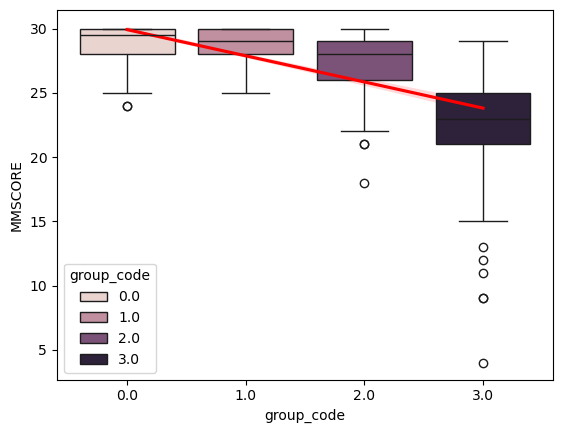

In [37]:
#some visual stats
import seaborn as sns

sns.boxplot(data=table_df, x='group_code', y='MMSCORE', hue='group_code')
sns.regplot(data=table_df, x='group_code', y='MMSCORE', scatter=False, color='r')

<Axes: xlabel='group_code', ylabel='moca_score'>

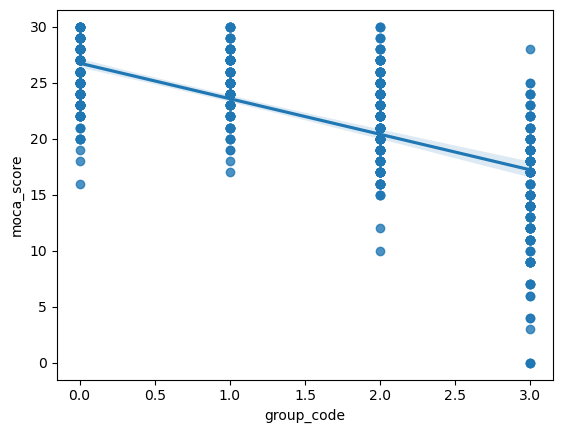

In [40]:
sns.regplot(data=table_df, x='group_code', y='moca_score', scatter=True)